## Basic Exploration of Datasets

In this initial section of the notebook, the focus is on the essential data cleaning and transformation processes needed to establish a robust dataset for the mineral exploration dashboard, specifically targeting rare earth elements (REEs).

### Raster Data Preparation
For the raster data, I will adjust the resolution to 250 meters, aligning it with the analytical scale. It's crucial to note that while this resolution is suitable in meters, when we transform the data into the EPSG:4269 Coordinate Reference System (CRS), the resolution will be expressed in degrees. This adjustment in CRS and resolution is critical for maintaining accurate spatial relationships across the dataset.

### Data Cleaning and Normalization
_[ON HOLD - GEOCHEM] To ensure data cleanliness and uniformity, we will perform extensive data cleaning and normalization. This includes removing duplicates, correcting any errors, and standardizing formats across different data sources. Spatial interpolation techniques will also be employed to estimate values for areas that were not directly sampled, based on the spatial correlation among measured points, thereby filling in any data gaps._

### Iterative Approach and Regional Focus
- **Initial Cleaning Scope**: Initially, the data cleaning efforts will be concentrated solely on the British Columbia province. This focused approach will help us in developing the MVP (Minimum Viable Product) for the dashboard.
- **Data Sources**: We will begin with radiometric data and plan to incorporate additional variables in future iterations of the project, progressively enriching our dataset.

### Import libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

# Import functions and reload the module after making changes
from scripts import utilities
import importlib
importlib.reload(utilities)
from scripts.utilities import read_shapefile, check_transform_crs, to_geodataframe


#General libraries
import pandas as pd
import geopandas as gdp
import os

#Raster
from osgeo import gdal, osr
import rasterio
from rasterio.plot import show


#Plotting
import matplotlib.pyplot as plt
from ipywidgets import interact, Dropdown

### Shapefiles
#### Admin boundaries
I will utilize polygons to perform "clipping" on raster datasets, initially focusing on British Columbia. This region is specifically chosen for its relevance in our database as a significant area for rare earth elements (REEs), particularly due to the Wicheeda deposit. Over time, I plan to expand the scope of our analysis to include Ontario and Quebec, the other provinces in our database known to possess REE deposits.

Please note that throughout this notebook, I will consistently use utility functions such as `read_shapefile` and `check_transform_crs` from the `utilities` module. This module serves as a central repository for commonly used functions, streamlining processes and ensuring consistency across the entire notebook.

In [3]:
path2 = r'datasets/shp/originals/admin_boundaries.shp'
admin = read_shapefile(path2)
admin=check_transform_crs(admin)

Shapefile loaded with 13 records
Columns: 7
Geometry type: ['MultiPolygon' 'Polygon']
CRS is already correct.


<Axes: >

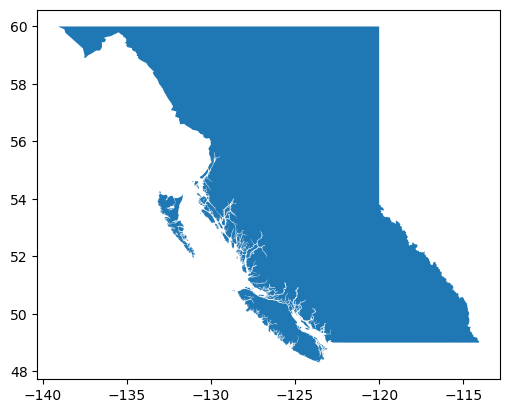

In [4]:
# target_province=admin[admin['PRENAME'].isin(['British Columbia','Nunavut','Ontario','Quebec','Yukon'])]
target_province=admin[admin['PRENAME'].isin(['British Columbia'])]#,'Ontario','Quebec'])]
target_province.plot()

#### Geology and Geochronology
The datasets used in this section are specifically tailored for British Columbia. Thus, they require only a verification of the Coordinate Reference System (CRS) to ensure they align correctly with our analysis parameters. Once this check is completed, the datasets will be ready for immediate use in our explorations.


In [10]:
# bc= read_shapefile('datasets\shp\originals\BC_bedrock_ll83.shp')
# bc=check_transform_crs(bc)
bc.head(1).iloc[:,10:20]

,mem_phase,rock_class,rock_type,rk_char,unit_desc,age_max,age_min,belt,terrane,basin
0,None,sedimentary rocks,"mudstone, siltstone, shale fine clastic sedime...",None,"Shale, argillite, slate, calcareous argillite,...",Upper Devonian,Permian,Omineca,Cassiar,None


<Axes: >

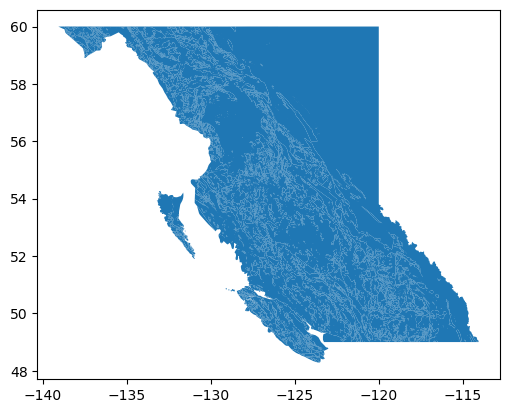

In [9]:
### for simplification we will use just de general lithology unit "rock_class"
bc_rocks=bc.dissolve(by='rock_class')
bc_rocks.reset_index(inplace=True)

In [6]:
new=to_geodataframe(r'datasets\new_age.csv','WGS84-lat','WGS84-long')
# NOTE: The "Sample age" field is not numeric. Six values are ranges such as "170-180".
# It might be useful to either convert these values into a numeric format or exclude them in later steps.

Error reading the file with utf-8. Trying with 'latin1' encoding...
GeoDataFrame created with 532 records
Geometry type: ['Point']
CRS=EPSG:4269


In [7]:
new.to_file(r'datasets\shp\geochronolyBC.shp')

#### Critical Minerales occurrences across Canada

In [2]:
path = "datasets\shp\originals\critical_minerals.shp"
CM = read_shapefile(path)
CM=check_transform_crs(CM)
CM.head(2)

Shapefile loaded with 270 records
Columns: 21
Geometry type: ['Point']
Transforming from EPSG:3978 to EPSG:4269.


,OBJECTID,OperationG,Operatio_1,PropertyNa,Property_1,OperatorOw,Operator_1,ProvincesE,ProvincesF,Commoditie,...,Developmen,Developm_1,ActivitySt,Activity_1,Latitude,Longitude,Website,ID,EA_Status,geometry
0,1,Mine,Mine,LaRonde,LaRonde,Agnico Eagle Mines Limited,Mines Agnico Eagle Limitée,Quebec,Québec,"Gold, zinc, copper, silver, cadmium",...,Mine,Mine,Active,En activité,48.2516,-78.428,https://agnicoeagle.com,1,None,POINT (-78.42800 48.25160)
1,2,Mine,Mine,Mount Brussilof,Mount Brussilof,Baymag Inc.,Baymag Inc.,British Columbia,Colombie-Britannique,"Magnesite (fused), magnesia (products)",...,Mine,Mine,Active,En activité,50.7887,-115.683,https://baymag.com,2,None,POINT (-115.68300 50.78870)


Given that a transformation has taken place, it is necessary to save this new GeoDataFrame as a shapefile for subsequent use in the analysis. However, I'll first performe a join with geological data to enrich the dataset.



In [ ]:
bc_rocks=bc.dissolve(by='rock_class')
bc_rocks.reset_index(inplace=True) 
#Intersect CM points with BC polygons
bc_cm=gdp.sjoin(CM,bc_rocks, how='inner', op='within')

#### Geoquem [ON HOLD]
I will hold off on progressing with the extensive analysis of over 65,000 sediment samples for critical mineral exploration, which is expected to outline efficient methodologies for such explorations of REE

In [34]:
# geoquem=pd.read_excel(r'datasets\rgs2020_data.xlsx')
# geoquem.head(2)

,MASTERID,ORIGINAL_REP,UPDATE_REP1,UPDATE_REP2,UPDATE_REP3,NAME,TYPE2,MAP250,MAP50,MAP20,...,W_INA_PPM,Yb_INA_PPM,Zn_INA_PPM,Zr_INA_PPM,WT_INA_g,pH,Uw_LIF_PPB,Fw_ISE_PPB,SO4_TRB_PPM,Cnd_uS/cm
0,ID082E091379,GBC 2010-13,NaN,NaN,NaN,QUEST SOUTH,STRM,082E,082E13,082E.091,...,-1.0,-2.0,NaN,220.0,44.58,7.80,NaN,19.0,NaN,17.0
1,ID082E091380,GBC 2010-13,NaN,NaN,NaN,QUEST SOUTH,STRM,082E,082E13,082E.091,...,-1.0,-2.0,NaN,-200.0,39.18,7.58,NaN,19.0,NaN,18.0


<Axes: >

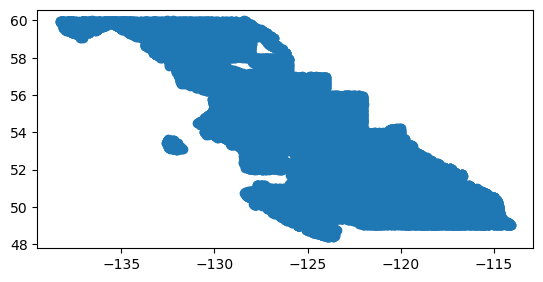

In [57]:
# ## Converting into GeoDataframe
# from shapely.geometry import Point
# geometry = [Point(xy) for xy in zip(geoquem['LONG'], geoquem['LAT'])]
# geoquem_geo = gdp.GeoDataFrame(geoquem, geometry=geometry)
# geoquem_geo.set_crs(epsg=4326, inplace=True)

##### Filtered data

In [60]:
# target_geoquem = geoquem_geo[geoquem_geo.within(target_province.unary_union)]
# # target_geoquem.plot()

### Interactivce map

In [41]:
##Interactive map targeting CM column 
column1_values = bc_cm['Developmen'].unique()
# column2_values = bc_cm['Developmen'].unique()

@interact(column1=column1_values)
def show_map(column1):

    fig, ax = plt.subplots(figsize=(10,10))
    
    #Rock type
    bc_rocks.plot(ax=ax, column='rock_class', legend=True, cmap='viridis')
    
    #Geocronology
    new.plot(ax=ax, color ='black', marker ='o', markersize=7, alpha=0.6)
    # Adding labels for geochronology points
    # for x, y, label in zip(new.geometry.x, new.geometry.y, new['Sample Age']):
    #     ax.text(x, y, label, fontsize=8, ha='right', color='black')

    #Filtering by value for interactive map
    data_filtered = bc_cm[bc_cm['Developmen'] == column1]
    data_filtered.plot(ax=ax, color='red', marker='o', markersize=7)

    ## Adding Wicheeda point of interest
    wicheeda = bc_cm[bc_cm['Commoditie']=='Rare earth elements']
    x = wicheeda.geometry.x.iloc[0]
    y = wicheeda.geometry.y.iloc[0]
    ax.scatter(x,y, color='white', marker='o', s=50)
    ax.text(x,y,'wich', fontsize=7, ha='left', color ='white')
   

    plt.title('BC simplyfied map by rock class')
    plt.show()

interactive(children=(Dropdown(description='column1', options=('Mine', 'Smelter', 'Smelter, refinery, plant', …

In [25]:
# bc_cm['Commoditie'] = bc_cm['Commoditie'].str.strip()
bc_cm[bc_cm['Commoditie']=='Rare earth elements'].values.flatten()


array([264, 'Project', 'Projet', 'Wicheeda', 'Wicheeda',
       'Defense Metals Corp.', 'Defense Metals Corp.', 'British Columbia',
       'Colombie-Britannique', 'Rare earth elements',
       'Éléments des terres rares', 'Advanced project', 'Projet avancé',
       'Active', 'En activité', 54.53141, -122.09912,
       'https://defensemetals.com', '264', None, <POINT (-122 54.5)>, 5,
       'sedimentary rocks', 32899, '3a407beb', 26984024.0, 'DPBC',
       'Paleozoic', 'Devonian to Permian', 'Upper Devonian to Permian',
       'Big Creek Group', 'Big Creek Group',
       'Yanks Peak, Midas, Mural and Dome Creek Formations',
       'Snippaker unit',
       'mudstone, siltstone, shale fine clastic sedimentary rocks',
       'siliceous',
       'Shale, argillite, slate, calcareous argillite, limestone, tuffaceous argillite, sandstone, wacke, dacite, tuffaceous dacite; equivalent to the Earn Group',
       'Upper Devonian', 'Permian', 'Omineca', 'Cassiar',
       'Whitehorse Trough', 'Lower

In [18]:

print([f'{col}: {len(bc_cm[col].unique())}' for col in bc_cm.columns])

['OBJECTID: 44', 'OperationG: 3', 'Operatio_1: 3', 'PropertyNa: 44', 'Property_1: 44', 'OperatorOw: 34', 'Operator_1: 34', 'ProvincesE: 1', 'ProvincesF: 1', 'Commoditie: 32', 'Commodit_1: 31', 'Developmen: 5', 'Developm_1: 5', 'ActivitySt: 2', 'Activity_1: 2', 'Latitude: 44', 'Longitude: 44', 'Website: 37', 'ID: 44', 'EA_Status: 1', 'geometry: 44', 'index_right: 5', 'rock_class: 5', 'gid: 5', 'upid: 5', 'area_m2: 5', 'strat_unit: 4', 'era: 3', 'period: 4', 'strat_age: 5', 'strat_name: 4', 'gp_suite: 4', 'fm_lithodm: 5', 'mem_phase: 5', 'rock_type: 4', 'rk_char: 5', 'unit_desc: 4', 'age_max: 5', 'age_min: 5', 'belt: 2', 'terrane: 3', 'basin: 3', 'basin_age: 3', 'project: 2', 'src_url: 2', 'src_ref_s: 2', 'map_comp: 2', 'edit_date: 1', 'pub_org: 1']


In [44]:
bc_cm[bc_cm['Commoditie']=='Rare earth elements'].iloc[:, 40:]
# len(bc_cm[bc_cm['Commoditie']=='Rare earth elements'].columns)

,terrane,basin,basin_age,project,src_url,src_ref_s,map_comp,edit_date,pub_org
263,Cassiar,Whitehorse Trough,Lower Jurassic,QUEST,http://cmscontent.nrs.gov.bc.ca/geoscience/Pub...,"Logan et al., 2010, QUEST, BCGS, Geoscience Ma...","Logan et al., 2010, QUEST",2019-12-19,British Columbia Geological Survey


In [75]:
CM[CM['Commoditie']=='Rare earth elements'].iloc[:,7:18]

,ProvincesE,ProvincesF,Commoditie,Commodit_1,Developmen,Developm_1,ActivitySt,Activity_1,Latitude,Longitude,Website
144,Quebec,Québec,Rare earth elements,Éléments des terres rares,Advanced project,Projet avancé,On hold / suspended,En attente / suspendu,46.817470,-78.474500,http://www.qpmcorp.ca
163,Quebec,Québec,Rare earth elements,Éléments des terres rares,Advanced project,Projet avancé,Active,En activité,56.945830,-68.404170,https://commerceresources.com
199,Northwest Territories,Territoires du Nord-Ouest,Rare earth elements,Éléments des terres rares,Advanced project,Projet avancé,Active,En activité,62.118060,-112.599720,https://vitalmetals.com.au
214,Newfoundland and Labrador,Terre-Neuve-et-Labrador,Rare earth elements,Éléments des terres rares,Advanced project,Projet avancé,On hold / suspended,En attente / suspendu,52.398330,-55.824170,Not available/Pas disponible
223,Saskatchewan,Saskatchewan,Rare earth elements,Éléments des terres rares,Advanced processing project,Projet de traitement avancé,Active,En activité,52.140033,-106.627370,https://www.src.sk.ca/campaigns/rare-earth-pro...
224,Ontario,Ontario,Rare earth elements,Éléments des terres rares,Demonstration plant,Usine de démonstration,Active,En activité,44.233334,-76.500000,https://ucore.com/rapidsx/
227,Quebec,Québec,Rare earth elements,Éléments des terres rares,Advanced unconventional project,Projet avancé non conventionnel,Active,En activité,45.525976,-73.340812,https://geomega.ca
230,Saskatchewan,Saskatchewan,Rare earth elements,Éléments des terres rares,Advanced processing project,Projet de traitement avancé,On hold / suspended,En attente / suspendu,52.176809,-106.656706,https://vitalmetals.com.au
232,Quebec,Québec,Rare earth elements,Éléments des terres rares,Advanced project,Projet avancé,On hold / suspended,En attente / suspendu,48.542770,-71.154450,https://www.magrispm.com
263,British Columbia,Colombie-Britannique,Rare earth elements,Éléments des terres rares,Advanced project,Projet avancé,Active,En activité,54.531410,-122.099120,https://defensemetals.com


In [4]:
CM[(CM['Commoditie']=='Rare earth elements') & (CM['ProvincesE'].isin(['Quebec','Ontario']))].iloc[:,10:]

,Commodit_1,Developmen,Developm_1,ActivitySt,Activity_1,Latitude,Longitude,Website,ID,EA_Status,geometry
144,Éléments des terres rares,Advanced project,Projet avancé,On hold / suspended,En attente / suspendu,46.817470,-78.474500,http://www.qpmcorp.ca,145,None,POINT (-78.47450 46.81747)
163,Éléments des terres rares,Advanced project,Projet avancé,Active,En activité,56.945830,-68.404170,https://commerceresources.com,164,None,POINT (-68.40417 56.94583)
224,Éléments des terres rares,Demonstration plant,Usine de démonstration,Active,En activité,44.233334,-76.500000,https://ucore.com/rapidsx/,225,None,POINT (-76.50000 44.23333)
227,Éléments des terres rares,Advanced unconventional project,Projet avancé non conventionnel,Active,En activité,45.525976,-73.340812,https://geomega.ca,228,None,POINT (-73.34081 45.52598)
232,Éléments des terres rares,Advanced project,Projet avancé,On hold / suspended,En attente / suspendu,48.542770,-71.154450,https://www.magrispm.com,233,None,POINT (-71.15445 48.54277)


In [82]:
palabras_clave = 'Canyon Creek'

# Crear una máscara que identifica si las palabras clave están presentes en alguna celda
mask = CM.applymap(lambda x: palabras_clave in str(x))

# Verificar si hay coincidencias en alguna parte del DataFrame
if mask.any().any():
    # Mostrar las filas donde aparecen las palabras clave
    filas_coincidentes = CM[mask.any(axis=1)]
    print(filas_coincidentes)
else:
    print("No se encontraron coincidencias con las palabras clave.")

No se encontraron coincidencias con las palabras clave.


### Rasters
#### Magnetic Total Field

In [23]:
dataset=None

In [21]:
wkt = dataset.GetProjection()
#Crear un objeto SpatialReference
srs = osr.SpatialReference(wkt=wkt)

print("Proyección:", srs.GetAttrValue('PROJCS'))
print("Nombre del sistema de coordenadas:", srs.GetAttrValue('GEOGCS'))


Proyección: None
Nombre del sistema de coordenadas: NAD83


In [24]:
def print_metadata(file_path):
    with rasterio.open(file_path) as src:
        print("CRS:", src.crs)
        print("Resolution:", src.res)
        print("Bounds:", src.bounds)
        print("Tags:", src.tags())

print_metadata(r'datasets\raster\cropped_reprojected_Canada - 250m - RAD - Equivalent Thorium eTh - 2012 - Geotif.TIF')


CRS: EPSG:4269
Resolution: (0.0035765398681473957, 0.0035765398681473957)
Bounds: BoundingBox(left=-139.05464004380985, bottom=48.30580040108625, right=-114.0510498255914, top=60.00108576992824)
Tags: {'AREA_OR_POINT': 'Area'}


 geojson = [mapping(geometry)]
The mapping function from shapely.geometry converts the geometric object into a GeoJSON-like Python dictionary. GeoJSON is a format for encoding geographic data structures. The mapping function essentially translates the shapely geometry into a format that rasterio can understand and use, specifically for the masking operation. The reason it is wrapped in a list ([mapping(geometry)]) is because the mask function from rasterio expects a list of GeoJSON geometries – this allows for multiple geometries to be used in the masking operation, though only one geometry is being used here.

In [4]:
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.mask import mask
from shapely.geometry import mapping

###MODIFICARER OUTPUT PATHS#######################

def process_and_reproject_rasters(raster_paths, polygon_gdf, output_directory, target_crs='EPSG:4269'):
    """
    Processes a list of rasters by ensuring they all have the CRS EPSG:4269,
    reprojects if necessary, and crops the rasters using a reference polygon.

    Args:
    raster_paths (list of str): Paths to the raster files.
    polygon_shapefile (str): Path to the shapefile containing the cropping polygon.
    output_directory (str): Directory where the cropped and reprojected rasters will be saved.
    target_crs (str): The target CRS to standardize all rasters (default 'EPSG:4269').
    """
    
    # Get the polygon as a geometric object
    geometry = polygon_gdf.iloc[0].geometry
    geojson = [mapping(geometry)]
    
    for raster_path in raster_paths:
        with rasterio.open(raster_path) as src:
            src_crs = src.crs
            if src_crs != target_crs:
                # Calculate the transformation needed and the new dimensions
                transform, width, height = calculate_default_transform(
                    src.crs, target_crs, src.width, src.height, *src.bounds)
                kwargs = src.meta.copy()
                kwargs.update({
                    'crs': target_crs,
                    'transform': transform,
                    'width': width,
                    'height': height
                })
                
                # Reproject the raster
                reprojected_path = f"{output_directory}/reprojected_{os.path.basename(raster_path)}"
                with rasterio.open(reprojected_path, 'w', **kwargs) as dst:
                    for i in range(1, src.count + 1):
                        reproject(
                            source=rasterio.band(src, i),
                            destination=rasterio.band(dst, i),
                            src_transform=src.transform,
                            src_crs=src.crs,
                            dst_transform=transform,
                            dst_crs=target_crs,
                            resampling=Resampling.nearest)
                raster_path = reprojected_path
            
            # Crop the raster using the polygon
            with rasterio.open(raster_path) as src:
                out_image, out_transform = mask(src, geojson, crop=True)
                out_meta = src.meta.copy()
                out_meta.update({
                    "driver": "GTiff",
                    "height": out_image.shape[1],
                    "width": out_image.shape[2],
                    "transform": out_transform
                })
                
                output_path = f"{output_directory}/cropped_{os.path.basename(raster_path)}"
                with rasterio.open(output_path, "w", **out_meta) as dest:
                    dest.write(out_image)

    print("All rasters processed to CRS EPSG:4269 and cropped as specified.")




In [11]:
raster_paths = [os.path.join(r'datasets\raster', f) for f in os.listdir(r'datasets\raster') if f.lower().endswith('.tif')]
output_directory = r'datasets\raster'
process_and_reproject_rasters(raster_paths, target_province, output_directory)

All rasters processed to CRS EPSG:4269 and cropped as specified.


In [30]:
def plot_raster(raster_path):
    """ Función para leer y graficar un raster. """
    if raster_path:
        with rasterio.open(raster_path) as src:
            fig, ax = plt.subplots(figsize=(10, 7))
            rasterio.plot.show(src, ax=ax, title=os.path.basename(raster_path))
            plt.show()

def list_rasters(directory):
    """ Lista todos los archivos TIFF en un directorio. """
    return [os.path.join(directory, f) for f in os.listdir(directory) if f.lower().endswith('.tif')]

@interact
def interactive_plot_raster(directory=r"datasets/raster"):
    rasters = list_rasters(directory)
    if rasters:  # Verifica si hay rasters disponibles
        raster_dropdown = Dropdown(options=rasters)
        interact(plot_raster, raster_path=raster_dropdown)
    else:
        print("No hay archivos TIFF en el directorio especificado.")


interactive(children=(Text(value='datasets/raster', description='directory'), Output()), _dom_classes=('widget…

Dropdown(options=('cropped_reprojected_Canada - 250m - RAD - Equivalent Uranium eU - 2012 - Geotif.TIF', 'crop…

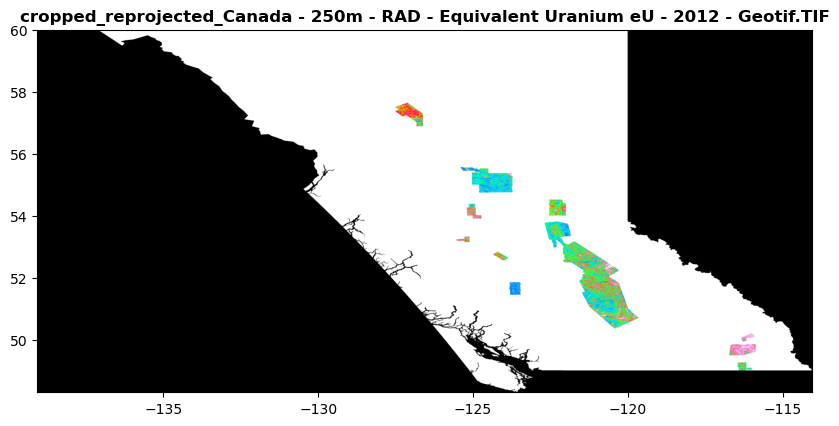

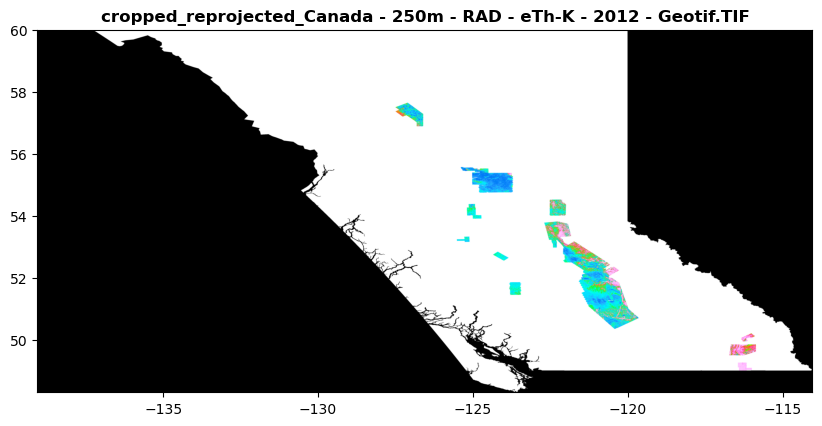

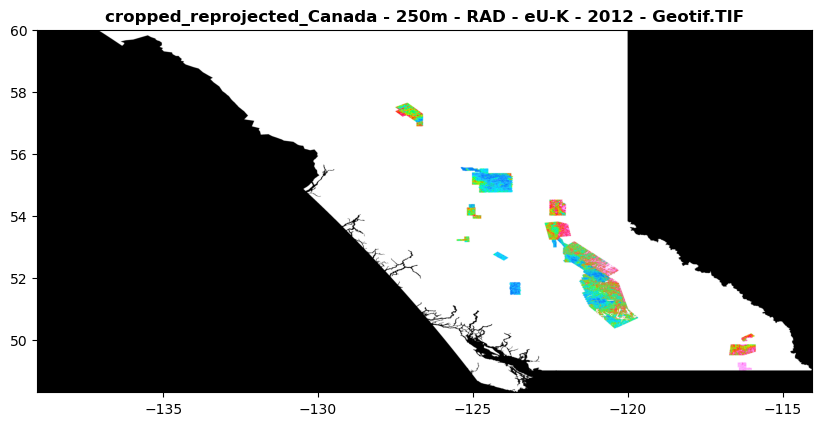

In [42]:
def plot_raster(raster_path):
    """Function to read and plot a raster."""
    with rasterio.open(raster_path) as src:
        fig, ax = plt.subplots(figsize=(10, 7))
        show(src, ax=ax, title=os.path.basename(raster_path))
        plt.show()

def list_rasters(directory):
    """Lists all TIFF files in a directory, returning a dictionary with file names and paths."""
    return {os.path.basename(f): os.path.join(directory, f) for f in os.listdir(directory) if f.lower().endswith('.tif')}

def interactive_plot_raster(directory):
    rasters = list_rasters(directory)
    if rasters:
        # Create a Dropdown with the file names
        raster_dropdown = Dropdown(options=list(rasters.keys()))
        def update_plot(change):
            plot_raster(rasters[change.new])  # Use the full path from the dictionary
        raster_dropdown.observe(update_plot, names='value')
        display(raster_dropdown)  # Display the dropdown
        plot_raster(list(rasters.values())[0])  # Plot the first raster initially
    else:
        print("No TIFF files found in the specified directory.")

# Set the fixed directory inside the function for simplicity
interactive_plot_raster(r"datasets/raster/cropped_reprojected")


prueba con punto weechida

In [47]:
def plot_raster(raster_path, poi):
    """
    Plot a raster file with a point of interest overlay.
    
    Args:
    raster_path (str): The path to the raster file.
    poi (GeoDataFrame): A GeoDataFrame containing the point of interest with geometry and label.
    
    Displays a raster plot with a point of interest marked on it.
    """
    with rasterio.open(raster_path) as src:
        fig, ax = plt.subplots(figsize=(10, 7))
        show(src, ax=ax, title=os.path.basename(raster_path))
        
        # Assuming poi has geometry and possibly a name column
        x, y = poi.geometry.x.iloc[0], poi.geometry.y.iloc[0]
        ax.scatter(x, y, color='red', marker='o', s=100)  # Adjust size and color as needed
        ax.text(x, y, "Wicheeda", fontsize=10, ha='left', va='top', color='red')  # Adjust label as needed
        
        plt.show()

def list_rasters(directory):
    """
    List all TIFF files in a specified directory.

    Args:
    directory (str): The directory path that contains TIFF files.

    Returns:
    dict: A dictionary mapping file names to their full paths.
    """
    return {os.path.basename(f): os.path.join(directory, f) for f in os.listdir(directory) if f.lower().endswith('.tif')}

def interactive_plot_raster(directory, poi):
    """
    Create an interactive raster plot selector with a predefined point of interest.

    Args:
    directory (str): The directory from which to list and select raster files.
    poi (GeoDataFrame): The GeoDataFrame containing the point of interest data.
    
    Displays a dropdown widget to select different raster files for plotting.
    """
    rasters = list_rasters(directory)
    if rasters:
        raster_dropdown = Dropdown(options=list(rasters.keys()))
        def update_plot(change):
            plot_raster(rasters[change.new], poi)
        raster_dropdown.observe(update_plot, names='value')
        display(raster_dropdown)
        plot_raster(list(rasters.values())[0], poi)  # Plot the first raster initially
    else:
        print("No TIFF files found in the specified directory.")




Dropdown(options=('cropped_reprojected_Canada - 250m - RAD - Equivalent Uranium eU - 2012 - Geotif.TIF', 'crop…

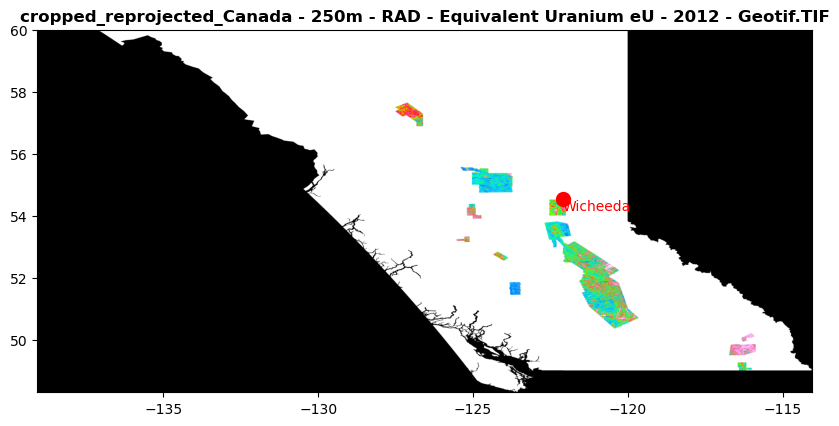

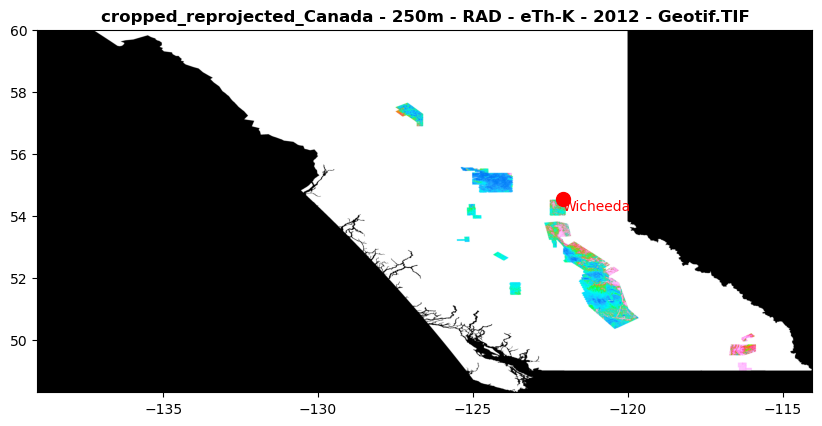

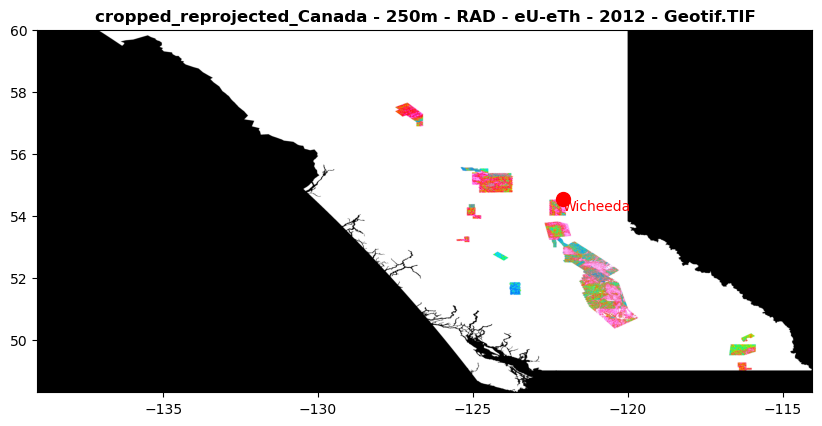

In [48]:
wicheeda = bc_cm[bc_cm['Commoditie']=='Rare earth elements']
# Example usage of the function with a directory and the point of interest loaded as GeoDataFrame
interactive_plot_raster(r"datasets/raster/cropped_reprojected", wicheeda)